In [1]:
import numpy as np
import pandas as pd

%run settings/plt_settings.ipynb
%run settings/db_connect.ipynb

In [73]:
prot_count = sql("""
select org.organism, n_org as swissprot, n_cafa as cafa3 , n_org_pe from
(select organism, count(*) n_org from swissprot group by organism) as org left join
(select organism, count(*) n_cafa from cafa_swissprot group by organism) as cafa
  on org.organism=cafa.organism join
  (select organism, count(*) n_org_pe from swissprot where pe='Evidence at protein level' group by organism) as sp_pe
  on org.organism=sp_pe.organism
order by n_cafa
""")

In [72]:
#prot_count.query(""" cafa3<=100  """).sum()['cafa3']
explained_origin = prot_count.query(""" cafa3>=100  """).sum()['cafa3'] / prot_count.sum()['cafa3']
print("Histogram explains %.2f%% of proteins"%explained_origin)
print("Histogram excludes %d organisms on y axis" % prot_count.query(""" cafa3<100  """).count()['cafa3'])

Histogram explains 0.93% of proteins
Histogram excludes 916 organisms on y axis


In [81]:
prot_count.count()

swissprot    2801
cafa3         939
n_org_pe     2801
dtype: int64

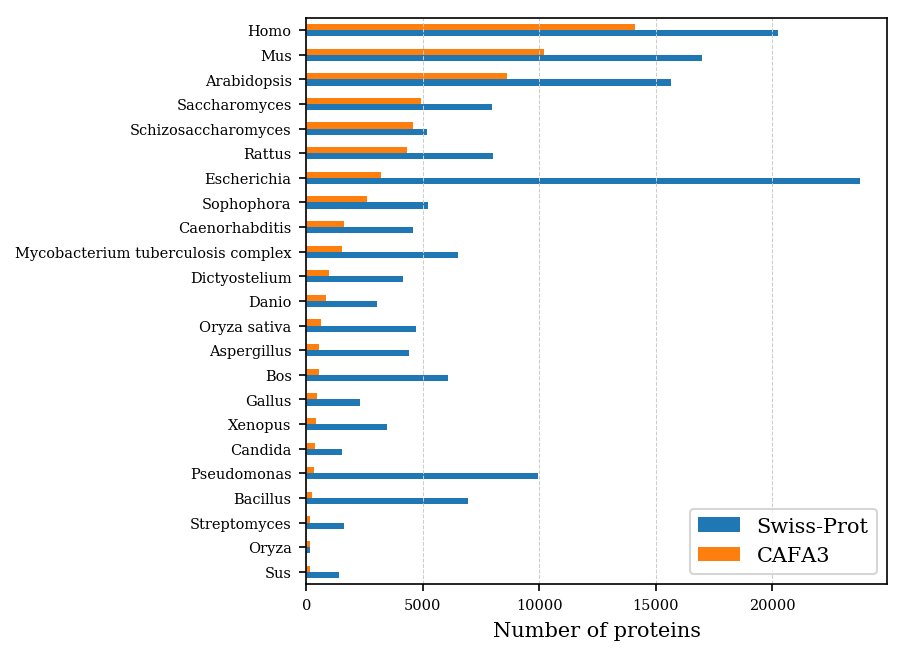

In [70]:
prot_count = prot_count[['swissprot', 'cafa3']]
ax = prot_count.query(""" cafa3>=100  """).plot(kind='barh', figsize=(5, 5))

ax.legend(["Swiss-Prot", "CAFA3"])
ax.set_xlabel("Number of proteins" )
ax.set_ylabel("")
ax.grid(which='major', axis='y')
plt.savefig('plots/dataset/sp_vs_cafa3.png', dpi=300, bbox_inches='tight')

In [71]:
pe_count = sql("""
select org.pe, n_org as swissprot, n_cafa as CAFA3 from
(select pe, count(*) n_org from swissprot group by pe) as org left join 
(select pe, count(*) n_cafa from cafa_swissprot group by pe) as cafa 
  on org.pe=cafa.pe
""")

pe2number = {
    "Uncertain": 0,
    "Predicted": 1,
    "Inferred from homology": 2,
    "Evidence at transcript level": 3,
    "Evidence at protein level": 4,   
}

pe_count['order'] = [pe2number[x] for x in pe_count.index]
pe_count.sort_values('order', inplace=True, ascending=False)
pe_count['label'] = ['Potvrđeno na nivou proteina','Potvrđeno na nivou RNK','Zaključeno iz homologije','Predviđen','Nesiguran' ]
pe_count

,swissprot,cafa3,order,label
pe,,,,
Evidence at protein level,97542,49250,4,Potvrđeno na nivou proteina
Evidence at transcript level,57085,11164,3,Potvrđeno na nivou RNK
Inferred from homology,386028,5144,2,Zaključeno iz homologije
Predicted,13675,877,1,Predviđen
Uncertain,1866,95,0,Nesiguran


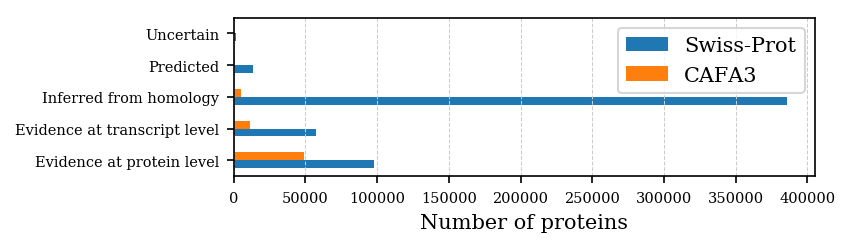

In [69]:
ax = pe_count[pe_count.columns[:-2]]\
              .plot.barh(figsize=(5, 1.4))

ax.legend(["Swiss-Prot", "CAFA3"])
ax.set_ylabel("")
ax.set_xlabel("Number of proteins" )
ax.grid(which='major', axis='y')
plt.savefig('plots/dataset/cafa3_pe.png', dpi=300, bbox_inches='tight')

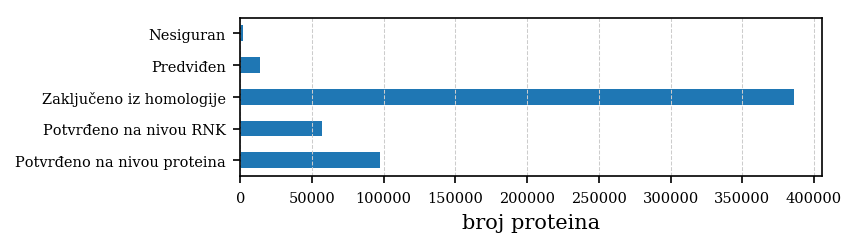

In [47]:
ax = pe_count.set_index('label')['swissprot']\
              .plot.barh(figsize=(5, 1.4))
ax.set_ylabel("")
ax.set_xlabel("broj proteina" )
ax.grid(which='major', axis='y')
plt.savefig('plots/PE.pdf', dpi=300, bbox_inches='tight')

In [115]:
df = pd.read_csv("db/mapping_swissprot.csv")

In [137]:
df.head()

,status,kw,go,score,n_kwgo,n_kw,n_go,R,kw_name,go_name,kw_def,go_def
0,NaN,KW-0687,GO:0019843,0.54,27660,50698,28317,1,Ribonucleoprotein,rRNA binding,Proteins conjugated with ribonucleic acid (RN...,Interacting selectively and non-covalently wit...
1,NaN,KW-0687,GO:0003735,0.46,31025,50698,48096,2,Ribonucleoprotein,structural constituent of ribosome,Proteins conjugated with ribonucleic acid (RN...,The action of a molecule that contributes to t...
2,NaN,KW-0687,GO:0003723,0.06,2928,50698,4428,3,Ribonucleoprotein,RNA binding,Proteins conjugated with ribonucleic acid (RN...,Interacting selectively and non-covalently wit...
3,NaN,KW-0687,GO:0000049,0.06,3258,50698,4870,4,Ribonucleoprotein,tRNA binding,Proteins conjugated with ribonucleic acid (RN...,Interacting selectively and non-covalently wit...
4,NaN,KW-0687,GO:0046872,0.02,971,50698,5010,5,Ribonucleoprotein,metal ion binding,Proteins conjugated with ribonucleic acid (RN...,Interacting selectively and non-covalently wit...


In [150]:
for row in df.itertuples():
    if row.R == 1:
        print(row.kw, row.kw_name)
        print(row.kw_def)
    ws = 4*" "
    print(ws, row.score, (row.n_kwgo, row.n_kw, row.n_go),  row.go, row.)
    break

KW-0687 Ribonucleoprotein
 Proteins conjugated with ribonucleic acid (RNA). Ribonucleoprotein are involved in a wide range of cellular processes. Besides ribosomes, in eukaryotic cells both initial RNA transcripts in the nucleus (hnRNA) and cytoplasmic mRNAs exist as complexes with specific sets of proteins. Processing (splicing) of the former is carried out by small nuclear RNPs (snRNPs). Other examples are the signal recognition particle responsible for targetting proteins to endoplasmic reticulum and a complex involved in termination of transcription
     0.54 (27660, 50698, 28317) GO:0019843


In [4]:
%run settings/db_connect.ipynb

In [15]:
ribonucleoprotein_set = set(sql("""
select prot from prot2kw
where kw='KW-0687'
""").index)

ribosomalprotein_set = set(sql("""
select prot from prot2kw
where kw='KW-0689'
""").index)

In [16]:
len(ribonucleoprotein_set), len(ribosomalprotein_set)

(1898, 1420)

In [19]:
len(ribonucleoprotein_set.intersection(ribosomalprotein_set))

1420